# Carbon estimation without land use data

## Importation of packages

In [68]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 

## Data importation

In [69]:
data = pd.read_excel(r'c:\Users\ACER\Documents\Projet IA\Datasets\Carbone_data.xlsx')
data.head(3)

,plot_id,Carbon,shdi,tree_prop,built_prop,crop_prop,NDVI,NDWI,LST,precip
0,1,1093464.625,0.981208,40.230665,0.000000,6.671190,0.331755,-0.347820,29.741554,1056.380493
1,2,1079817.250,1.006183,33.192248,0.155937,8.777010,0.332725,-0.348426,29.744902,1055.794556
2,3,1066844.625,1.024424,42.771219,0.000000,10.069058,0.333561,-0.348948,29.747845,1055.053711


## Exploratory data analysis 

In [70]:
data_select = data[['plot_id', 'Carbon', 'NDVI', 'NDWI','LST', 'precip']] ## Select key variables without landscape variables 
data_select['Carbon_ha'] = data_select['Carbon'] / 400 ## Calculate carbon by ha. Any spatial unit have area f 4 km² = 400 ha

C:\Users\ACER\AppData\Local\Temp\ipykernel_6660\570838299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_select['Carbon_ha'] = data_select['Carbon'] / 400 ## Calculate carbon by ha. Any spatial unit have area f 4 km² = 400 ha


##  Data preprocessing for machine learning

## Packages importation

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression
import xgboost as xgb 

### Data split

In [72]:
y = data_select['Carbon_ha'] ## Predicted variables
x = data_select.drop(['Carbon_ha', 'Carbon'], axis = 1) ## Drop Carbon_ha and Carbon variables 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state= 42) ## Data split test size = 15 % 

## Machine learning

### Models specifications 

In [73]:
models = {
    'LR' : LinearRegression(), 
    'RF' : RandomForestRegressor(random_state = 42, n_estimators = 100), 
    'XGB' : xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.01, random_state = 42), 
    'AD_Boost' : AdaBoostRegressor(n_estimators = 100, learning_rate= 1, random_state = 42)
}

### Loop for models training and evaluation

Model : LR, R² = 0.21, RMSE = 354.64
Model : RF, R² = 0.72, RMSE = 212.52
Model : XGB, R² = 0.62, RMSE = 247.94
Model : AD_Boost, R² = 0.45, RMSE = 296.00


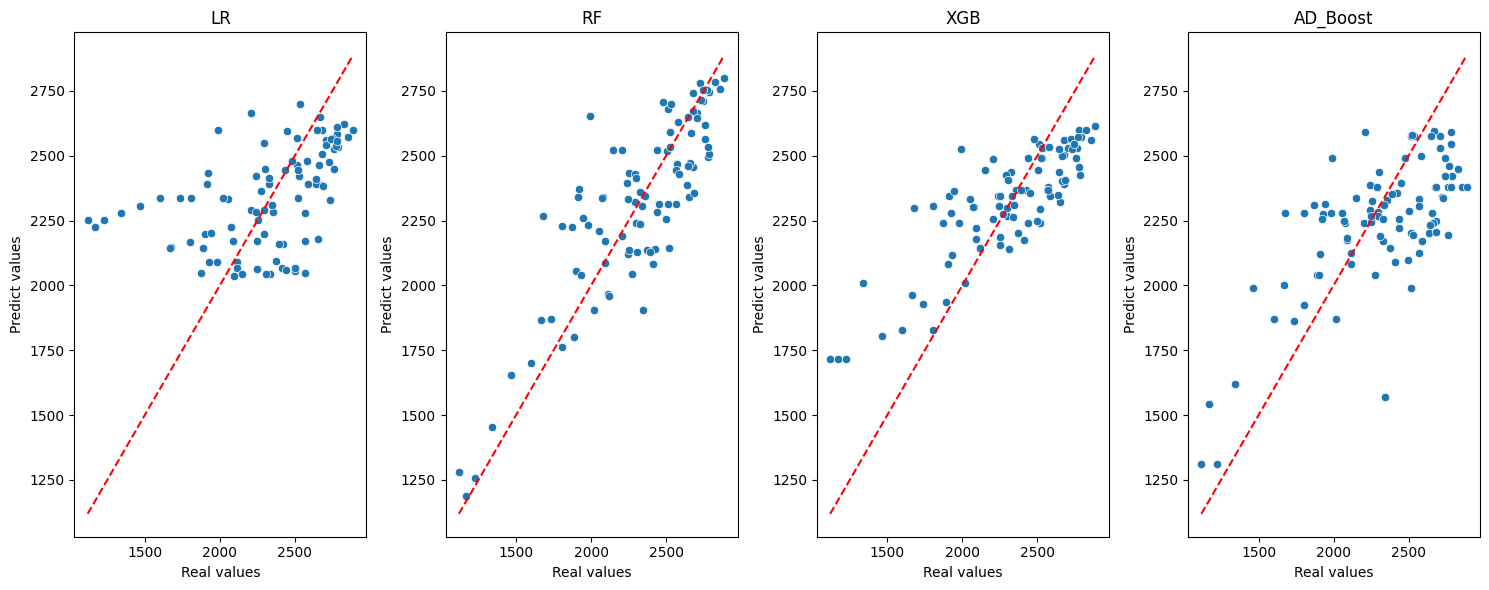

In [74]:
##Initialisation of best metrics

best_rmse = float('Inf') 
best_model = None 
best_r2 = 0 
plt.figure(figsize = (15, 6))

groups_train = x_train['plot_id'] ## Kfold groups 
x_train_clean = x_train.drop(columns=['plot_id']) ##Clean x_train
x_test_clean = x_test.drop(columns=['plot_id']) ##Clean y_train

for i, (name, model) in enumerate(models.items(), 1) : 
    pipe = Pipeline([('Scaler', StandardScaler()), 
                         ('Model', model)]) ##Pipeline 
    group_fold = GroupKFold(n_splits = 5) ##Spatial fold 

    pipe.fit(x_train_clean, y_train) ## Train of models 

    cv = cross_val_score(pipe, x_train_clean, y_train, groups = groups_train, cv = group_fold, scoring = 'r2') ##Cross validation of the model 

    ##Model evaluation 
    y_pred = pipe.predict(x_test_clean) ##Model prediction 
    r2 = r2_score(y_test, y_pred) ##R² calculation 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) ## RMSE calculation

    print(f'Model : {name}, R² = {r2:.2f}, RMSE = {rmse:.2f}')

    ##Graphics
    plt.subplot(1, len(models), i) 
    sns.scatterplot(x = y_test, y = y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Real values')
    plt.ylabel('Predict values')
    plt.title(name)

plt.tight_layout()
plt.show()

## SHAP Analysis on the best model

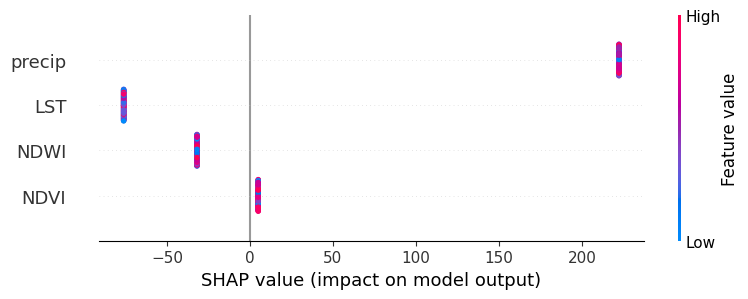

In [75]:
rf_pipe = Pipeline([
    ('Scaler', StandardScaler()), 
    ('model', RandomForestRegressor(random_state = 42, n_estimators = 100))]) ## Random Forest pipeline 

rf_pipe.fit(x_train_clean, y_train) ##RF model training

model = rf_pipe.named_steps['model']

# SHAP for RF Model analysis 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_clean) 
shap.summary_plot(shap_values, x_test_clean)

### Data frame

In [80]:
shap_data = pd.DataFrame(shap_values, columns = x_test_clean.columns)
shap_data = shap_data.mean()
print(shap_data)

NDVI        4.933303
NDWI      -31.978758
LST       -76.184011
precip    222.405548
dtype: float64


### Barplot 

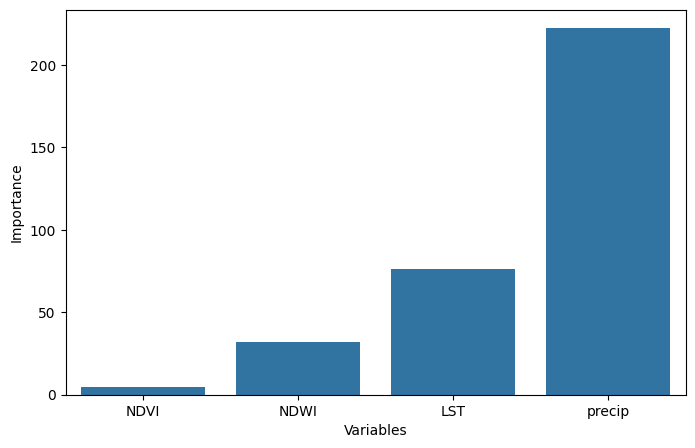

In [77]:
plt.figure(figsize = (8, 5))
sns.barplot(shap_data.abs())
plt.xlabel('Variables')
plt.ylabel('Importance') 
plt.show()

## Dependances graphics

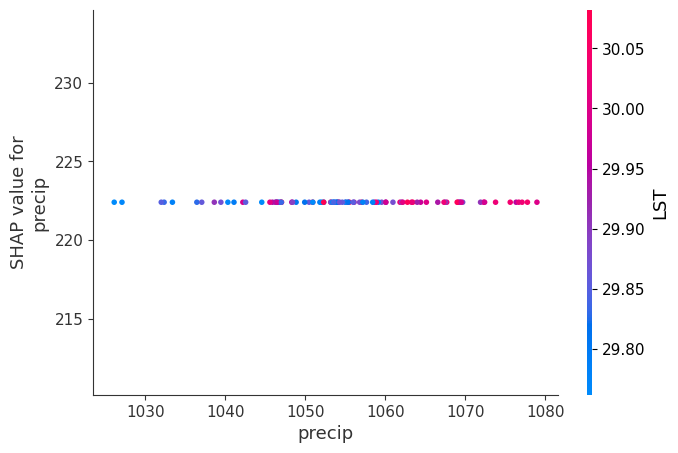

In [78]:
shap.dependence_plot('precip', shap_values, x_test_clean, interaction_index = 'LST')